2024-12-16 03:27:06.316572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Activities with >80% False motion_value:
PID: P06, Activity: FFSIT, Proportion of False: 1.00
PID: P11, Activity: FFSIT, Proportion of False: 0.96


/var/folders/xt/j055vd5n66x6nhkm2f0zzg2w0000gn/T/ipykernel_81084/4176642520.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])


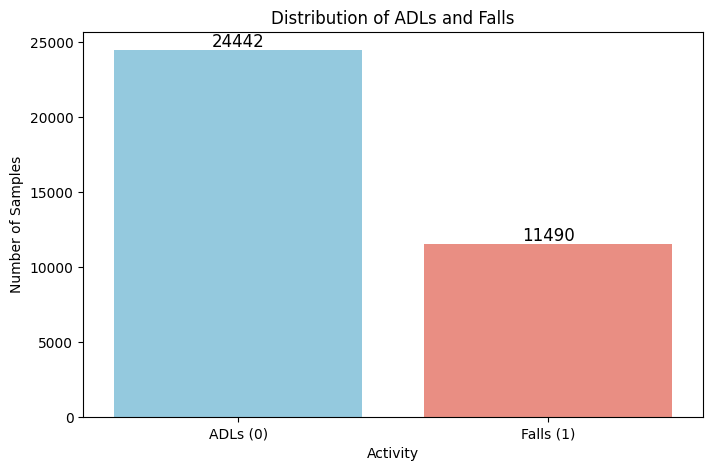

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, LSTM, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

def plot_performance(history):
    # plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def remove_zero_readings(df, threshold=10):
    """Remove records with zero readings above threshold."""
    # Track problematic sensor combinations
    zero_readings = pd.DataFrame()
    for sensor in ['breathingRate', 'heartRate']:
        zero_counts = df[df[sensor] == 0.0].groupby(['PID', 'activity_name'])[sensor].count()
        zero_readings = pd.concat([zero_readings, zero_counts[zero_counts > threshold]])
    
    # Remove identified problematic records
    outlier_indices = zero_readings.index.drop_duplicates()
    return df[~df.set_index(['PID', 'activity_name']).index.isin(outlier_indices)]


df = pd.read_csv("combined_sensor_data-all-7.csv")

# ignore one hot encoded and netatmo and static 
# health_idx_columns = ['health_idx_0', 'health_idx_1', 'health_idx_2', 'health_idx_3', 'health_idx_4']
# physiologicalState_columns = ['physiologicalState_0', 'physiologicalState_1', 'physiologicalState_2','physiologicalState_3', 'physiologicalState_4']
# df = df.drop(['targetDistance','CO2','Humidity','Noise','Pressure','AbsolutePressure',
            #   'age','gender','height','weight','fitness_level'] + physiologicalState_columns + health_idx_columns, axis=1)

# remove redundant 
df = df.drop(['targetDistance', 'AbsolutePressure'], axis=1)

# feature engineering 
def combine_ambient(df, ambient_features):
    # Step 1: Select only ambient sensor features (CO2, Humidity, Noise, Pressure)
    ambient_df = df[ambient_features]

    # Step 2: Handle NaN values by filling with the mean
    ambient_df = ambient_df.fillna(ambient_df.mean())

    # Step 3: Standardize the ambient sensor features
    scaler = StandardScaler()
    ambient_features_scaled = scaler.fit_transform(ambient_df)
    # Step 4: Apply PCA to create the Environmental Index
    pca = PCA(n_components=1)  # Aggregate into a single component
    env_index = pca.fit_transform(ambient_features_scaled)
    # Add the Environmental Index to the original DataFrame
    df['environmental_index'] = env_index
    # Display the updated DataFrame
    # df.drop(ambient_features)
    # print(df.columns)
    df = df.drop(ambient_features, axis=1)
    return df


# Define the activities
fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]
non_fall_activities = ["LOB", "RS", "SBS", "SIT", "SSS", 'SSW', "SWW", "TWC", "WAT", 'WSS']
ambient_features = ['CO2', 'Humidity', 'Noise', 'Pressure']

def remove_low_motion_activities(df, threshold=0.8):
    """
    Print and remove fall activities where motion_value is False 
    for more than the threshold percentage of the activity's duration.
    """
    # List of fall activities to check
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    # Filter for fall activities only
    falls_df = df[df['activity_name'].isin(fall_activities)]

    # Calculate percentage of False motion values for each (PID, activity_name)
    motion_stats = (
        falls_df.groupby(['PID', 'activity_name'])['motion_value']
        .apply(lambda x: (x == False).mean())  # Calculate proportion of False values
    )

    # Identify activities to print and remove based on the threshold
    activities_to_remove = motion_stats[motion_stats > threshold]

    # Print the activity names and their proportions before removing
    print("Activities with >80% False motion_value:")
    for (pid, activity_name), proportion in activities_to_remove.items():
        print(f"PID: {pid}, Activity: {activity_name}, Proportion of False: {proportion:.2f}")

    # Remove identified activities from the DataFrame
    return df[~df.set_index(['PID', 'activity_name']).index.isin(activities_to_remove.index)]

def identify_and_remove_outliers_combined(df):
    """
    Identify outliers for both ADL and Fall activities using IQR and remove them from the dataset.
    Retain all other information and merge cleaned activities back.
    """
    # Group by base_activity, class, and PID to calculate the duration per activity
    duration_counts = df.groupby(['base_activity', 'class', 'PID']).size().reset_index(name='duration')

    # Separate ADLs and Falls
    adls = duration_counts[duration_counts['class'] == 0]  # ADL activities
    falls = duration_counts[duration_counts['class'] == 1]  # Fall activities

    # Helper function to identify and clean outliers using IQR
    def clean_outliers(data):
        outliers = []
        cleaned_data = []

        for activity in data['base_activity'].unique():
            activity_data = data[data['base_activity'] == activity]
            Q1 = activity_data['duration'].quantile(0.25)
            Q3 = activity_data['duration'].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers and non-outliers
            activity_outliers = activity_data[
                (activity_data['duration'] < lower_bound) | (activity_data['duration'] > upper_bound)
            ]
            activity_cleaned = activity_data[
                (activity_data['duration'] >= lower_bound) & (activity_data['duration'] <= upper_bound)
            ]

            outliers.append(activity_outliers)
            cleaned_data.append(activity_cleaned)

        # Combine all outliers and cleaned data
        all_outliers = pd.concat(outliers, ignore_index=True)
        all_cleaned_data = pd.concat(cleaned_data, ignore_index=True)

        return all_outliers, all_cleaned_data

    # Clean outliers for ADLs and Falls separately
    adl_outliers, cleaned_adls = clean_outliers(adls)
    fall_outliers, cleaned_falls = clean_outliers(falls)

    # Print identified outliers
    print("\nIdentified ADL Outliers:")
    print(adl_outliers[['base_activity', 'PID', 'duration']])

    print("\nIdentified Fall Outliers:")
    print(fall_outliers[['base_activity', 'PID', 'duration']])

    # Combine cleaned ADLs and Falls
    cleaned_df = pd.concat([cleaned_adls, cleaned_falls], ignore_index=True)

    # Merge cleaned activities with the original DataFrame to retain all columns
    final_df = df.merge(cleaned_df[['base_activity', 'PID']], on=['base_activity', 'PID'], how='inner')

    return final_df


# 2. Apply cleaning steps
df = remove_zero_readings(df)
df['motion_value'] = df['motion_value'].astype(int)
df = remove_low_motion_activities(df)
# df_2 = identify_and_remove_outliers_combined(df)

df_clean = df.drop(ambient_features, axis=1)
df_ambient = combine_ambient(df, ambient_features)

def filter_activities(df):
    # Define relevant fall activities
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    non_fall_activities = [
            "LOB", "RS", "SBS", 
            "SWW", "TWC", "WAT", 
            'WSS', 'SSW', 'SSS'
        ]

    # Filter the dataset to keep only relevant activities
    df_filtered = df[df['base_activity'].isin(fall_activities + non_fall_activities)]
    return df_filtered

final_df_clean = filter_activities(df_clean)
final_df_ambient = filter_activities(df_ambient)

def plot_class_distribution(df):
    """
    Plot the distribution of ADLs (class=0) and Falls (class=1) with sample counts.
    """
    # Get the class distribution
    class_counts = df['class'].value_counts().reset_index()
    class_counts.columns = ['class', 'count']
    class_counts['label'] = class_counts['class'].apply(lambda x: 'ADLs (0)' if x == 0 else 'Falls (1)')

    # Plot the distribution using a bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])

    # Add labels on top of the bars
    for index, row in class_counts.iterrows():
        plt.text(index, row['count'], f'{row["count"]}', ha='center', va='bottom', fontsize=12)

    # Add plot labels and title
    plt.title("Distribution of ADLs and Falls")
    plt.xlabel("Activity")
    plt.ylabel("Number of Samples")
    plt.show()

plot_class_distribution(final_df_ambient)

# final_df
# 19195/10583
# print(len(final_df_clean.columns)) # 14 features
# print(final_df_clean.columns) # 14 features
# print(final_df_ambient.columns) # 14 features
# print(df_clean.columns) # 14 features with all ADLs

# print(df_clean.shape)
# print(final_df_clean.shape)

# CNN-LSTM

In [3]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, TimeDistributed
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Flatten, TimeDistributed, MaxPooling1D
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Flatten, Dropout, Input, Permute, Multiply
def build_cnn_bilstm_hybrid_model(input_shape, optimizer='adam', filters=32, kernel_size=3, lstm_units=64, learning_rate=0.001):
    model = Sequential()
    
    # Apply Conv1D layer to each time step using TimeDistributed
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'), 
                              input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))  # Optional pooling layer
    model.add(TimeDistributed(Flatten()))  # Flatten the output of Conv1D
    
    # Use Bidirectional LSTM
    model.add(Bidirectional(LSTM(lstm_units)))  # BiLSTM layer

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Flatten, Dropout, Input, Permute, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# this one
def build_cnn_bilstm_hybrid_model_2(input_shape, optimizer='adam', filters=64, lstm_units=64, learning_rate=0.001):
    # Input layer
    inputs = Input(shape=input_shape)  # Shape should be (11, 9)

    # 1D Convolutional Layer
    conv_out = Conv1D(filters=filters, kernel_size=3, activation='relu')(inputs)  # Output shape: (11, 7, 64)

    # Dropout layer
    dropout1 = Dropout(0.5)(conv_out)

    # Bidirectional LSTM Layer
    bilstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(dropout1)  # Output shape: (11, 128)

    # Second Dropout Layer
    dropout2 = Dropout(0.5)(bilstm_out)

    # Dense Layer
    dense_out = Dense(128, activation='relu')(dropout2)  # Output shape: (11, 128)

    # Attention mechanism
    attention_vec = Permute((1, 2))(dense_out)  # Change shape to (11, 128) to (128, 11)
    attention_mul = Multiply()([dropout2, attention_vec])  # Now both should be (11, 128)

    # Flatten Layer
    flatten_out = Flatten()(attention_mul)

    # Output Layer
    outputs = Dense(1, activation='sigmoid')(flatten_out)

    # Create Model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [4]:
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import ADASYN
from typing import Tuple
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import plot_model

plt.style.use('default')


def plot_advanced_metrics(y_test, y_pred_probs, model_name="CNN Model"):
    """
    Create publication-quality ROC and Precision-Recall curves
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    avg_precision = average_precision_score(y_test, y_pred_probs)
    
    ax2.plot(recall, precision, color='darkgreen', lw=2,
             label=f'PR curve (AP = {avg_precision:.3f})')
    ax2.axhline(y=np.sum(y_test)/len(y_test), color='navy', lw=2, linestyle='--',
                label='Random classifier')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    return roc_auc, avg_precision

def analyze_threshold_impact(y_test, y_pred_probs):
    """
    Analyze impact of different classification thresholds using numpy operations
    """
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix elements using numpy
        tn = np.sum(np.logical_and(y_test == 0, y_pred == 0))
        fp = np.sum(np.logical_and(y_test == 0, y_pred == 1))
        fn = np.sum(np.logical_and(y_test == 1, y_pred == 0))
        tp = np.sum(np.logical_and(y_test == 1, y_pred == 1))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    # Plot threshold impact
    plt.figure(figsize=(10, 6))
    thresholds = [r['threshold'] for r in results]
    plt.plot(thresholds, [r['precision'] for r in results], 
             label='Precision', marker='o')
    plt.plot(thresholds, [r['recall'] for r in results], 
             label='Recall', marker='s')
    plt.plot(thresholds, [r['f1'] for r in results], 
             label='F1-score', marker='^')
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Impact of Classification Threshold on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()
    return results

def find_optimal_threshold(results):
    """Find threshold with highest F1 score"""
    return max(results, key=lambda x: x['f1'])['threshold']

def format_threshold_results(results):
    """Format threshold results as string"""
    text = ""
    for r in results:
        text += f"\n   Threshold {r['threshold']:.1f}:"
        text += f" Precision={r['precision']:.3f},"
        text += f" Recall={r['recall']:.3f},"
        text += f" F1={r['f1']:.3f}"
    return text


def evaluate_model_advanced(model, X_test, y_test):
    """
    Main function to generate all advanced metrics
    """
    # Get predictions and ensure they're the right shape
    y_pred_probs = model.predict(X_test, verbose=0)
    if len(y_pred_probs.shape) > 1 and y_pred_probs.shape[1] == 1:
        y_pred_probs = y_pred_probs.ravel()
    
    # Generate ROC and PR curves
    roc_auc, avg_precision = plot_advanced_metrics(y_test, y_pred_probs)
    
    # Analyze threshold impact
    threshold_results = analyze_threshold_impact(y_test, y_pred_probs)
    
    # Generate summary
    summary = f"""
    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): {roc_auc:.4f}

    2. Precision-Recall Analysis:
    - Average Precision (AP): {avg_precision:.4f}

    3. Threshold Analysis:
    Optimal threshold based on F1-score: {find_optimal_threshold(threshold_results):.2f}
    
    Performance at different thresholds:
    {format_threshold_results(threshold_results)}
    """
    
    print(summary)
    return roc_auc, avg_precision, threshold_results



def print_window_dataset_info(X, y, stage=""):
    """
    Print detailed information about windowed dataset
    """
    print(f"\n{'='*20} {stage} {'='*20}")
    print(f"Dataset shape: {X.shape}")  # (n_samples, window_size, n_features)
    print(f"Labels shape: {y.shape}")   # (n_samples,)
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    print("\nClass Distribution:")
    print("-----------------")
    for class_label, count in zip(unique, counts):
        percentage = (count / total_samples) * 100
        print(f"Class {class_label}: {count} samples ({percentage:.2f}%)")


def create_sliding_windows_normal(data, window_size=8, step_size=1):
    """Create sliding windows across the entire dataset without grouping."""
    windows = []
    labels = []
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Iterate through the dataset to create sliding windows
    for i in range(0, len(features_df) - window_size + 1, step_size):
        # Extract a window of features and normalize it
        window = features_df.iloc[i:i + window_size].values
        normalized_window = normalize_window(window)

        # Store the normalized window and corresponding label (from 'class' column)
        windows.append(normalized_window)
        labels.append(data['class'].iloc[i + window_size - 1])  # Label corresponds to the last row in the window

    return np.array(windows), np.array(labels)


# new
def create_sliding_windows2(data, window_size=8, step_size=1):
    """Create sliding windows within each activity, ensuring activities are not mixed."""
    windows = []
    labels = []

    # Extract feature columns and ensure they are numeric
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Group by participant and activity to maintain boundaries
    for _, group in data.groupby(['PID', 'activity_name']):
        group = group.reset_index(drop=True)

        # Handle any NaN values resulting from coercion
        group = group.fillna(0)  # Replace NaN values with 0 or use other imputation methods

        # Only process windows of the desired size
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]

            # Normalize the window
            normalized_window = normalize_window(window[features_df.columns].values)

            windows.append(normalized_window)
            labels.append(window['class'].mode()[0])  # Assign the most frequent class in the window

    return np.array(windows), np.array(labels)


def normalize_window(window):
    """Normalize each sliding window independently (channel-wise)."""
    epsilon = 1e-10  # To prevent division by zero
    mean = window.mean(axis=0)  # Mean per feature
    std = window.std(axis=0)  # Std per feature
    return (window - mean) / (std + epsilon)


def apply_ros(X_train, y_train):
    """
    Apply Random OverSampling (ROS) to balance the dataset.
    """
    ros = RandomOverSampler(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape for ROS
    X_resampled, y_resampled = ros.fit_resample(X_train_reshaped, y_train)
    print(f"Data after ROS: {X_resampled.shape[0]} samples")
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)
    print(f"Data after SMOTE: {X_resampled.shape[0]} samples")

    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    # Reshape the data for ADASYN (flatten each sample into 2D for the algorithm)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = adasyn.fit_resample(X_train_reshaped, y_train)
    
    print(f"Data after ADASYN: {X_resampled.shape[0]} samples")
    
    # Reshape back to the original shape of X_train
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled


def apply_mu_sigma(X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Augments training data using Mu-Sigma augmentation technique.
    Doubles the training data by creating synthetic signals with added/subtracted noise.
    
    Args:
        X_train (np.ndarray): Training data of shape (n_samples, n_timesteps[, n_features])
        y_train (np.ndarray): Training labels
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Augmented training data and corresponding labels
    """
    # Generate noise for each sample in training data
    noise = np.zeros_like(X_train)
    
    # Calculate noise for each sample independently
    for i in range(len(X_train)):
        # Calculate standard deviation of current sample
        sigma = np.std(X_train[i])
        # Generate noise with zero mean and sample's standard deviation
        noise[i] = np.random.normal(loc=0, scale=sigma, size=X_train[i].shape)
    
    # Create augmented samples
    X_plus_noise = X_train + noise
    X_minus_noise = X_train - noise
    
    # Combine original and augmented data
    X_augmented = np.vstack((X_train, X_plus_noise, X_minus_noise))
    y_augmented = np.concatenate((y_train, y_train, y_train))
    
    # Shuffle the augmented dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented


def apply_gan_augmentation(X_train, y_train, num_samples=100, noise_dim=100, hidden_dim=64, num_epochs=100):
    """
    Generate synthetic time-series data using a GAN and augment the training set.
    
    Parameters:
    - X_train: Original training data (features)
    - y_train: Original training labels
    - num_samples: Number of synthetic sequences to generate
    - noise_dim: Dimensionality of the random noise vector
    - hidden_dim: Hidden layer size for both Generator and Discriminator
    - num_epochs: Number of epochs to train the GAN
    
    Returns:
    - X_augmented: Augmented feature set (X_train + synthetic samples)
    - y_augmented: Augmented labels set (y_train + synthetic labels)
    """

    # Get sequence length from X_train (assume [n_samples, seq_len, features])
    seq_len = X_train.shape[1]
    feature_dim = X_train.shape[2]

    # Define the Generator
    class Generator(nn.Module):
        def __init__(self, noise_dim, hidden_dim, output_dim):
            super(Generator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(noise_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

        def forward(self, noise):
            return self.model(noise)

    # Define the Discriminator
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Discriminator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )

        def forward(self, data):
            return self.model(data)

    # Initialize the Generator and Discriminator
    generator = Generator(noise_dim, hidden_dim, seq_len * feature_dim)
    discriminator = Discriminator(seq_len * feature_dim, hidden_dim)

    # Optimizers and loss function
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # Function to generate random noise
    def generate_noise(batch_size, noise_dim):
        return torch.randn(batch_size, noise_dim)

    # Train the GAN
    batch_size = 32
    for epoch in range(num_epochs):
        # === Train Discriminator ===
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = torch.tensor(X_train[idx].reshape(batch_size, -1), dtype=torch.float32)
        fake_data = generator(generate_noise(batch_size, noise_dim)).detach()

        # Discriminator loss
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        d_loss_real = criterion(discriminator(real_data), real_labels)
        d_loss_fake = criterion(discriminator(fake_data), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Backprop for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        noise = generate_noise(batch_size, noise_dim)
        generated_data = generator(noise)

        g_loss = criterion(discriminator(generated_data), real_labels)  # Fool the discriminator

        # Backprop for Generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate synthetic data
    noise = generate_noise(num_samples, noise_dim)
    synthetic_data = generator(noise).detach().numpy()
    synthetic_data = synthetic_data.reshape(num_samples, seq_len, feature_dim)

    # Create synthetic labels (1 for falls or any minority class, as needed)
    synthetic_labels = np.ones(num_samples)

    # Concatenate synthetic data with original training data
    X_augmented = np.concatenate((X_train, synthetic_data), axis=0)
    y_augmented = np.concatenate((y_train, synthetic_labels), axis=0)

    return X_augmented, y_augmented


def weighted_binary_crossentropy(weight_for_1):
    """
    Custom weighted binary cross-entropy loss.
    weight_for_1: Weight for positive class (falls, class = 1).
    """
    def loss_fn(y_true, y_pred):
        # Compute the standard binary cross-entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)

        # Apply weights: higher weight for class 1 (falls)
        weight_vector = y_true * weight_for_1 + (1. - y_true) * 1.0  # Class 0 gets weight 1.0

        # Return the weighted loss
        return K.mean(weight_vector * bce)

    return loss_fn


def get_all_metrics(model, X_test, y_test, model_name):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = recall_score(y_test, y_pred) # Sensitivity (Recall)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred) # test accuracy
    f1 = f1_score(y_test, y_pred)
    print(f"######## Confusion matrix for {model_name} model ########")
    print(f"Sensitivity (Recall): {sensitivity*100:.4f}%")
    print(f"Specificity: {specificity*100:.4f}%")
    print(f"Precision: {precision*100:.4f}%")
    print(f"Test Accuracy: {accuracy*100:.4f}%")
    print(f"F1 Score: {f1*100:.4f}%")
    print("################################################")
    metrics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1
    }
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    # print("\nClassification Imbalanced Report:")
    # print(classification_report_imbalanced(y_test, y_pred))
    return metrics


def kfold_model_performance(data, build_model_fn=None, augmentation_fn=None, second_aug_fn=None, gan_fn=None, window_size=11, step_size=1, n_splits=5, epochs=100):
  
    # Preprocess data
    # Step 2: Generate sliding windows and labels
    windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)

    # print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    X_train, X_test, y_train, y_test = train_test_split(
        windows, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

    # Step 4: Apply oversampling (ROS or SMOTE) on the training data only 
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
        desc =  f"Training Set After {augmentation_fn.__name__}"
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        desc = "Training set: NO Sampling"
    
    if second_aug_fn:
        X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
        desc = f"Training Set After Second Aug: {second_aug_fn.__name__}"

    if gan_fn:
        X_train_resampled, y_train_resampled = gan_fn(X_train_resampled, y_train_resampled)
        desc = f"Training Set After GAN Aug: {gan_fn.__name__}"

    print_window_dataset_info(X_train_resampled, y_train_resampled, desc)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0

    # X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], -1)  # Add channel dimension if needed
    # X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], X_train_resampled.shape[2], 1)  # Add channel dimension if needed

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Step 5: Build and compile the 1D CNN model
        
        input_shape = (X_fold_train.shape[1], X_fold_train.shape[2]) 
        # input_shape = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], -1)  # Add channel dimension if needed
        # input_shape = (X_fold_train.shape[1], X_fold_train.shape[2], 1) 
        # input_shape = X_train_resampled.reshape((X_train_resampled.shape[0], X_train_resampled.shape[1], X_train_resampled.shape[2]))
        # input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])  # Exclude batch size
        print("X_train_resampled shape:", X_train_resampled.shape)
        print("Input shape for model:", input_shape)
        
        model = build_model_fn(input_shape=input_shape)
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            # callbacks=[EarlyStopping(patience=10)],
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
    
    # return cv_scores, best_model, history, X_test, y_test
    # X_test = X_test.reshape(X_test.shape[0], 11, 9)  # Make sure this matches your training input shape
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }
    
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_test_pred))
    print("\nClassification Report (Imbalanced):")
    print(classification_report_imbalanced(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history


# CNN-BiLSTM - NONE

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training set: NO Sampling ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

Fold 1/5
X_train_resampled shape: (19360, 11, 9)
Input shape for model: (11, 9)
Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7209 - loss: 0.6062 - val_accuracy: 0.7105 - val_loss: 0.5577
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7248 - loss: 0.5628 - val_accuracy: 0.7247 - val_loss: 0.5506
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7406 - loss: 0.5409 - val_accuracy: 0.7342 - val_loss: 0.5413
Epoch 4/10

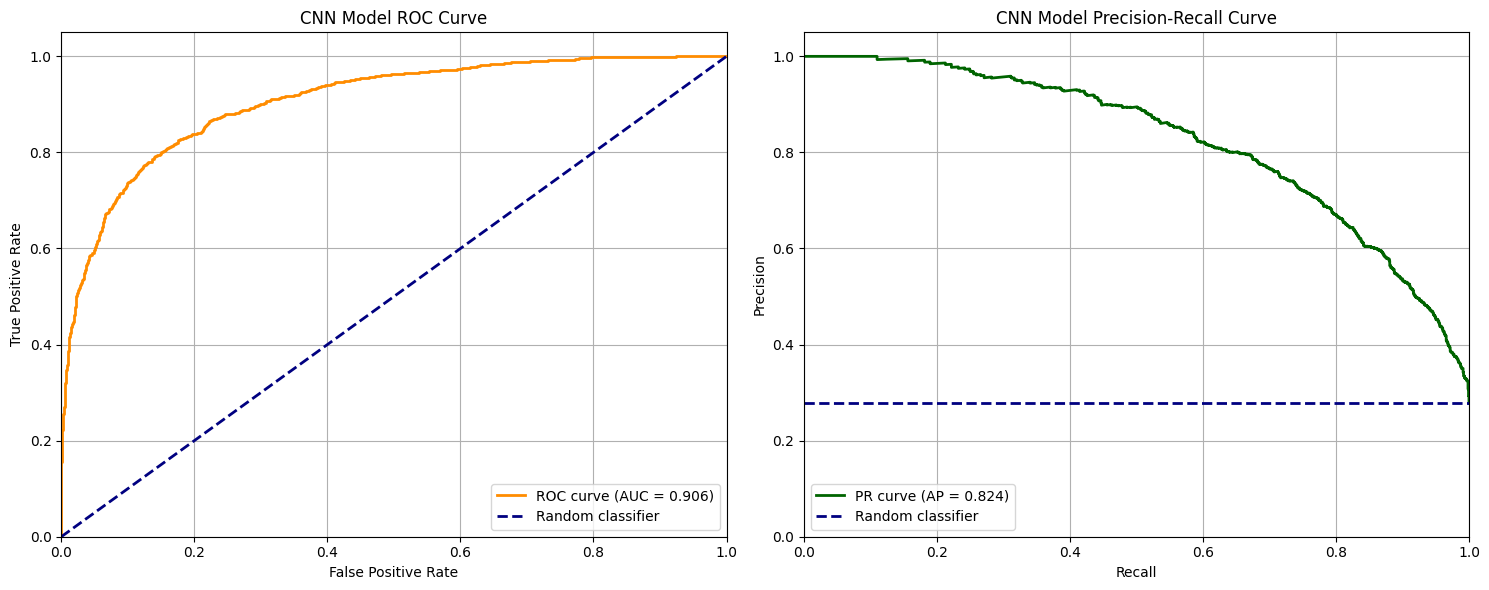

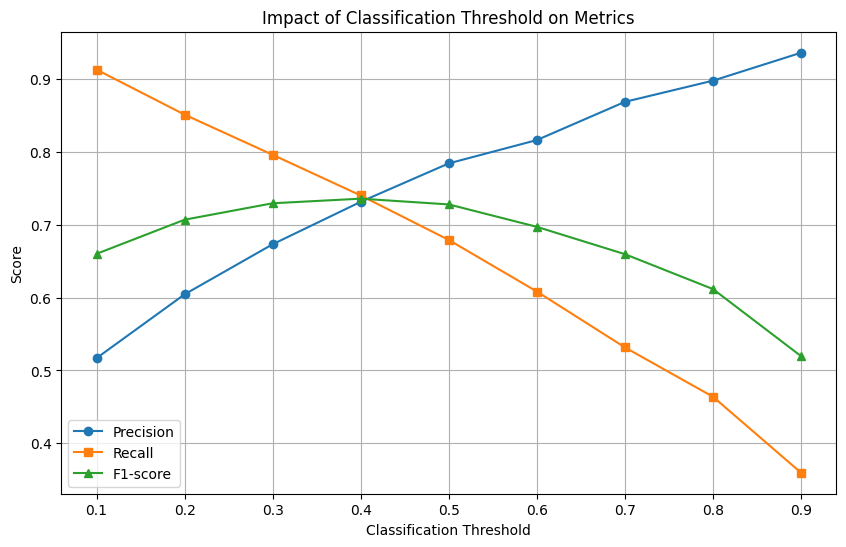


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9060

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8240

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.517, Recall=0.913, F1=0.660
   Threshold 0.2: Precision=0.604, Recall=0.851, F1=0.707
   Threshold 0.3: Precision=0.673, Recall=0.796, F1=0.729
   Threshold 0.4: Precision=0.731, Recall=0.740, F1=0.736
   Threshold 0.5: Precision=0.784, Recall=0.679, F1=0.728
   Threshold 0.6: Precision=0.816, Recall=0.608, F1=0.697
   Threshold 0.7: Precision=0.869, Recall=0.532, F1=0.660
   Threshold 0.8: Precision=0.898, Recall=0.464, F1=0.612
   Threshold 0.9: Precision=0.936, Recall=0.360, F1=0.520
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Cross-Validation Results:
Accuracy: 0.8560 ± 0.0029
Precision: 0.7757 ± 0.0172
Recall: 0.6781 ± 0.0217
F1: 0.7231 ± 0.0074

Test Set

In [5]:
# cnn-bilstm
cv_scores1, test_metrics1, best_model1, history1 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_bilstm_hybrid_model_2, augmentation_fn=None, 
    window_size=11, step_size=1
)

# CNN-BiLSTM - Mu-sigma

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training Set After apply_mu_sigma_new ====================
Dataset shape: (30102, 11, 9)
Labels shape: (30102,)

Class Distribution:
-----------------
Class 0: 13989 samples (46.47%)
Class 1: 16113 samples (53.53%)

Fold 1/5
X_train_resampled shape: (30102, 11, 9)
Input shape for model: (11, 9)
Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6944 - loss: 0.5052 - val_accuracy: 0.8261 - val_loss: 0.3654
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8176 - loss: 0.3762 - val_accuracy: 0.8254 - val_loss: 0.3644
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8291 - loss: 0.3582 - val_accuracy: 0.8303 - val_loss: 0.

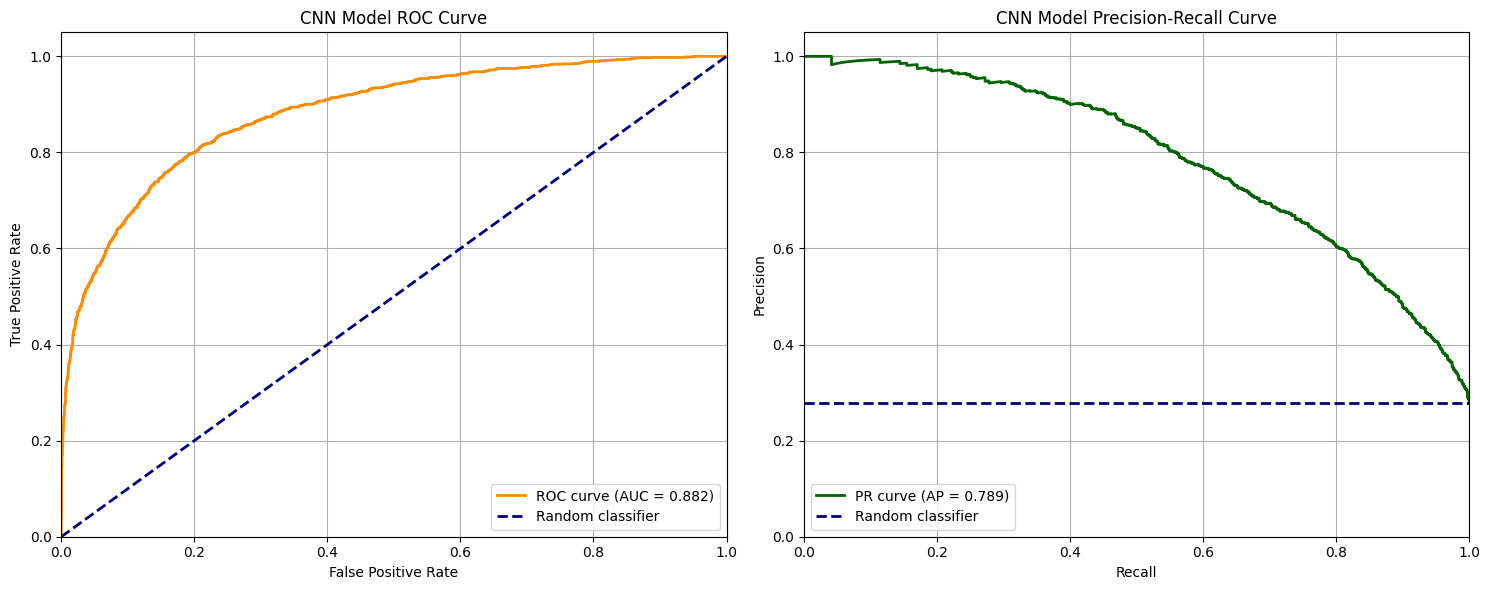

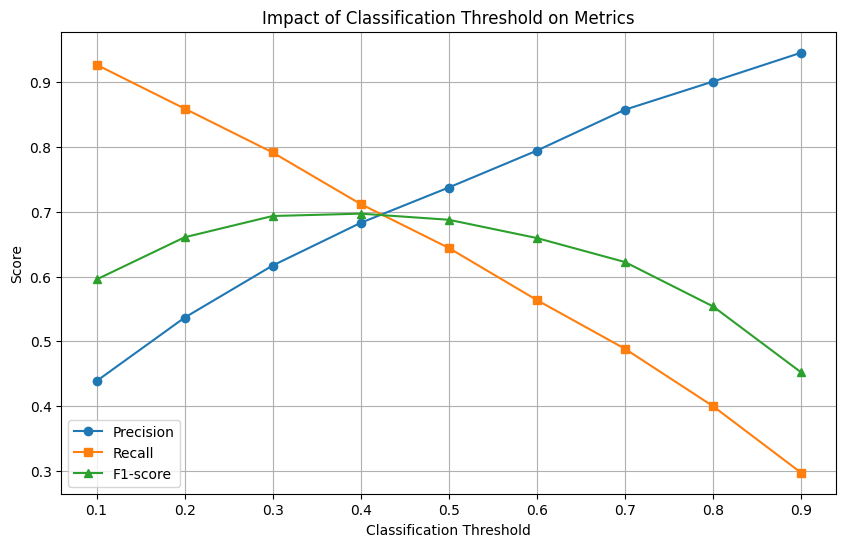


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8820

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.7885

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.439, Recall=0.927, F1=0.595
   Threshold 0.2: Precision=0.536, Recall=0.859, F1=0.661
   Threshold 0.3: Precision=0.617, Recall=0.792, F1=0.693
   Threshold 0.4: Precision=0.683, Recall=0.712, F1=0.697
   Threshold 0.5: Precision=0.737, Recall=0.644, F1=0.688
   Threshold 0.6: Precision=0.794, Recall=0.564, F1=0.659
   Threshold 0.7: Precision=0.858, Recall=0.488, F1=0.622
   Threshold 0.8: Precision=0.901, Recall=0.400, F1=0.554
   Threshold 0.9: Precision=0.945, Recall=0.297, F1=0.452
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Cross-Validation Results:
Accuracy: 0.8956 ± 0.0048
Precision: 0.9262 ± 0.0072
Recall: 0.8747 ± 0.0080
F1: 0.8997 ± 0.0047

Test Set

In [6]:
def apply_mu_sigma_new(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Balances the dataset using Mu-Sigma augmentation by selectively augmenting the minority class.
    This function returns a balanced dataset in the format (X_augmented, y_augmented).
    
    Args:
        X (np.ndarray): Original dataset (n_samples, n_timesteps, n_features).
        y (np.ndarray): Corresponding labels (n_samples,).

    Returns:
        Tuple[np.ndarray, np.ndarray]: Balanced and shuffled dataset.
    """
    # Identify the minority and majority class based on class distribution
    class_labels, class_counts = np.unique(y, return_counts=True)
    minority_class = class_labels[np.argmin(class_counts)]
    majority_class = class_labels[np.argmax(class_counts)]

    # Split the original data into majority and minority class subsets
    X_majority = X[y == majority_class]
    X_minority = X[y == minority_class]

    # Mu-Sigma augmentation on the minority class
    n_minority_samples = X_minority.shape[0]
    n_timesteps, n_features = X.shape[1], X.shape[2]

    # Initialize array for augmented minority data
    X_minority_augmented = np.zeros((n_minority_samples * 3, n_timesteps, n_features))

    for i in range(n_minority_samples):
        sample = X_minority[i]
        sigma = np.std(sample, axis=0, keepdims=True)  # Feature-wise standard deviation
        noise = np.random.normal(loc=0, scale=sigma, size=sample.shape)

        # Add original, +noise, and -noise versions to the augmented data
        X_minority_augmented[i] = sample
        X_minority_augmented[n_minority_samples + i] = sample + noise
        X_minority_augmented[2 * n_minority_samples + i] = sample - noise

    # Create labels for the augmented minority data
    y_minority_augmented = np.full(X_minority_augmented.shape[0], minority_class)

    # Combine the augmented minority class with the majority class
    X_augmented = np.vstack((X_majority, X_minority_augmented))
    y_augmented = np.concatenate((np.full(X_majority.shape[0], majority_class), y_minority_augmented))

    # Shuffle the combined dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]

    return X_augmented, y_augmented
# cnn-bilstm 
cv_scores2, test_metrics2, best_model2, history2 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_bilstm_hybrid_model_2, augmentation_fn=apply_mu_sigma_new, 
    window_size=11, step_size=1
)

# CNN-BiLISTM - SMOTE

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after SMOTE: 27978 samples

==================== Training Set After apply_smote ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5
X_train_resampled shape: (27978, 11, 9)
Input shape for model: (11, 9)
Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5464 - loss: 0.6812 - val_accuracy: 0.6262 - val_loss: 0.6448
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6395 - loss: 0.6445 - val_accuracy: 0.6571 - val_loss: 0.6335
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6595 - loss: 0.6230 - val_acc

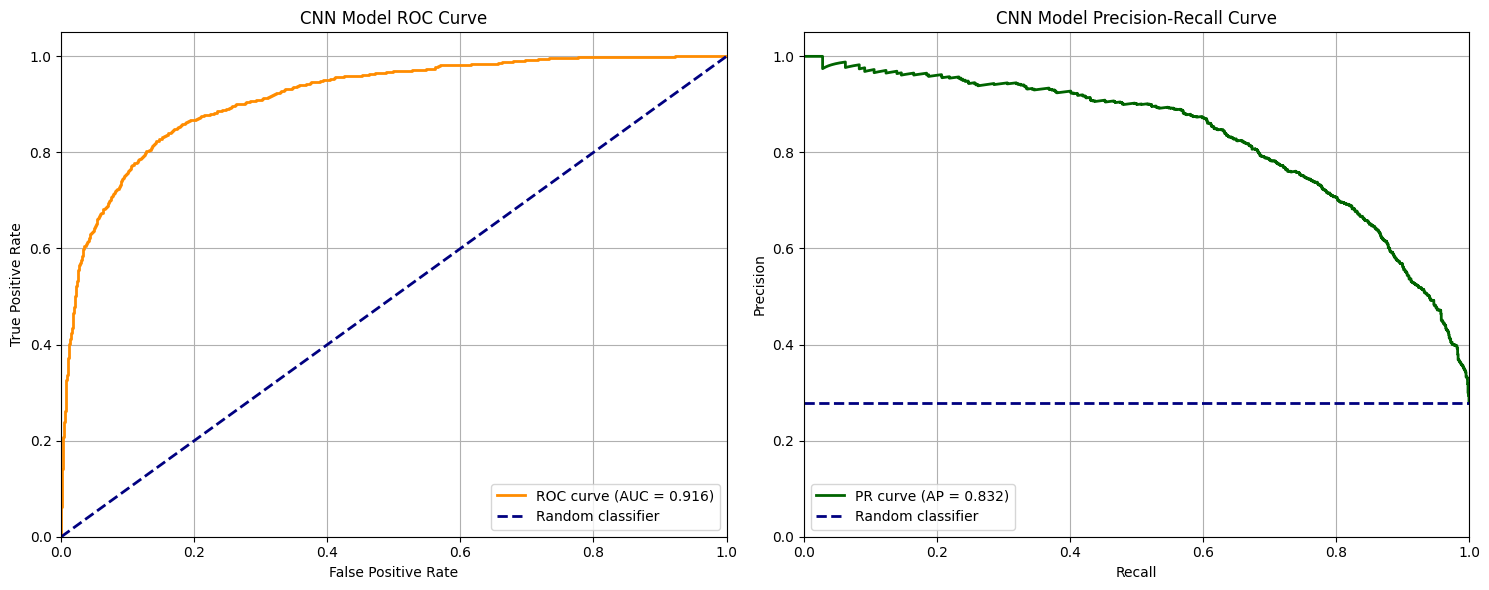

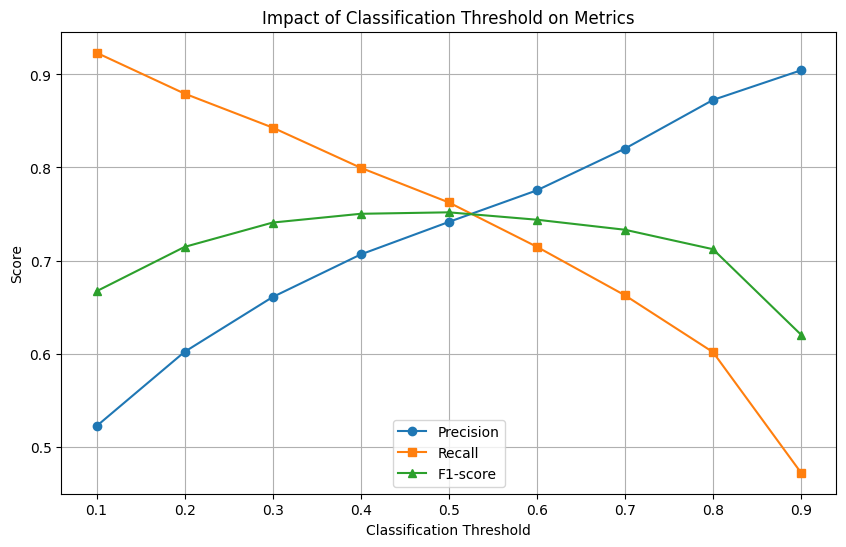


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9158

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8317

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.50
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.522, Recall=0.923, F1=0.667
   Threshold 0.2: Precision=0.602, Recall=0.879, F1=0.715
   Threshold 0.3: Precision=0.661, Recall=0.843, F1=0.741
   Threshold 0.4: Precision=0.707, Recall=0.800, F1=0.750
   Threshold 0.5: Precision=0.741, Recall=0.762, F1=0.752
   Threshold 0.6: Precision=0.775, Recall=0.715, F1=0.744
   Threshold 0.7: Precision=0.820, Recall=0.663, F1=0.733
   Threshold 0.8: Precision=0.873, Recall=0.602, F1=0.712
   Threshold 0.9: Precision=0.904, Recall=0.472, F1=0.620
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Cross-Validation Results:
Accuracy: 0.9066 ± 0.0085
Precision: 0.8739 ± 0.0207
Recall: 0.9515 ± 0.0126
F1: 0.9107 ± 0.0067

Test Set

In [7]:
cv_scores3, test_metrics3, best_model3, history3 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_bilstm_hybrid_model_2, augmentation_fn=apply_smote, 
    window_size=11, step_size=1
)

# CNN-BiLSTM - ADASYN

In [ ]:
plot_performance(history4)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after ADASYN: 26919 samples

==================== Training Set After apply_adasyn ====================
Dataset shape: (26919, 11, 9)
Labels shape: (26919,)

Class Distribution:
-----------------
Class 0: 13989 samples (51.97%)
Class 1: 12930 samples (48.03%)

Fold 1/5
X_train_resampled shape: (26919, 11, 9)
Input shape for model: (11, 9)
Epoch 1/100
673/673 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5488 - loss: 0.6849 - val_accuracy: 0.6244 - val_loss: 0.6593
Epoch 2/100
673/673 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6124 - loss: 0.6603 - val_accuracy: 0.6477 - val_loss: 0.6353
Epoch 3/100
673/673 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6407 - loss: 0.6358 - val_acc

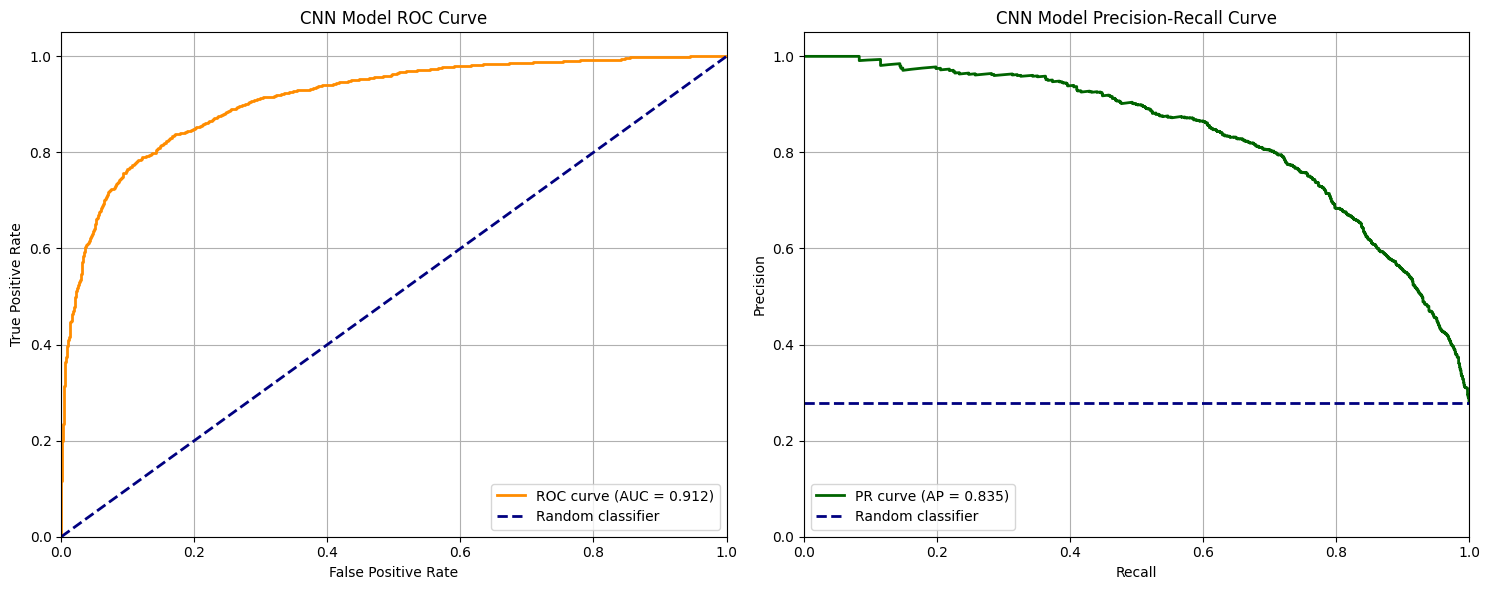

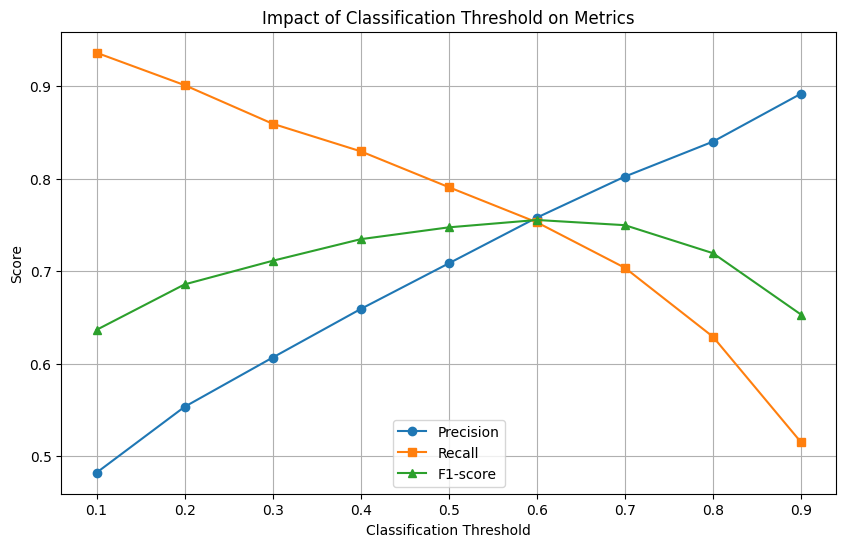


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9118

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8355

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.60
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.482, Recall=0.936, F1=0.637
   Threshold 0.2: Precision=0.554, Recall=0.901, F1=0.686
   Threshold 0.3: Precision=0.607, Recall=0.859, F1=0.711
   Threshold 0.4: Precision=0.659, Recall=0.829, F1=0.735
   Threshold 0.5: Precision=0.708, Recall=0.791, F1=0.747
   Threshold 0.6: Precision=0.758, Recall=0.753, F1=0.755
   Threshold 0.7: Precision=0.802, Recall=0.704, F1=0.750
   Threshold 0.8: Precision=0.840, Recall=0.629, F1=0.719
   Threshold 0.9: Precision=0.892, Recall=0.515, F1=0.653
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Cross-Validation Results:
Accuracy: 0.9000 ± 0.0063
Precision: 0.8605 ± 0.0112
Recall: 0.9453 ± 0.0073
F1: 0.9008 ± 0.0057

Test Set

In [8]:
cv_scores4, test_metrics4, best_model4, history4 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_bilstm_hybrid_model_2, augmentation_fn=apply_adasyn, 
    window_size=11, step_size=1
)

# CNN-BiLSTM - ROS

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after ROS: 27978 samples

==================== Training Set After apply_ros ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5
X_train_resampled shape: (27978, 11, 9)
Input shape for model: (11, 9)
Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5619 - loss: 0.6763 - val_accuracy: 0.6551 - val_loss: 0.6321
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6466 - loss: 0.6361 - val_accuracy: 0.6685 - val_loss: 0.6184
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6522 - loss: 0.6253 - val_accuracy:

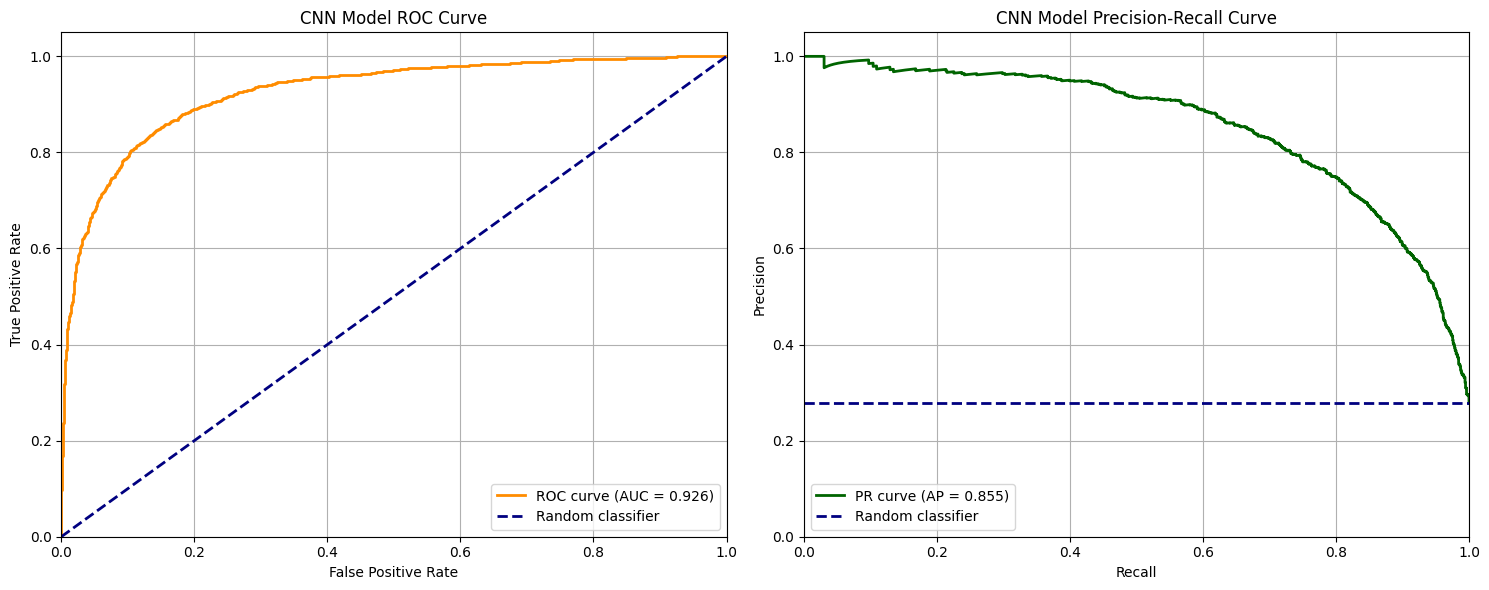

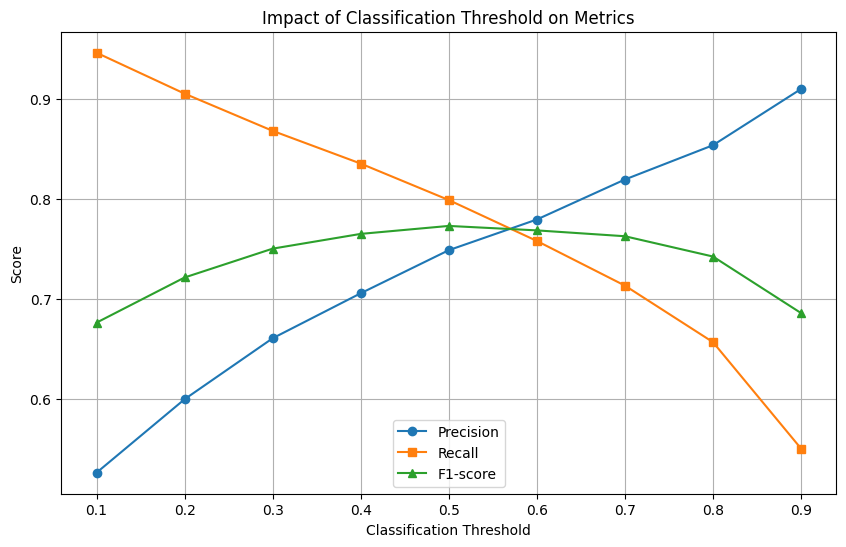


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9257

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8545

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.50
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.526, Recall=0.946, F1=0.676
   Threshold 0.2: Precision=0.600, Recall=0.905, F1=0.721
   Threshold 0.3: Precision=0.661, Recall=0.868, F1=0.750
   Threshold 0.4: Precision=0.706, Recall=0.835, F1=0.765
   Threshold 0.5: Precision=0.749, Recall=0.799, F1=0.773
   Threshold 0.6: Precision=0.779, Recall=0.758, F1=0.769
   Threshold 0.7: Precision=0.820, Recall=0.713, F1=0.763
   Threshold 0.8: Precision=0.854, Recall=0.657, F1=0.742
   Threshold 0.9: Precision=0.910, Recall=0.550, F1=0.686
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Cross-Validation Results:
Accuracy: 0.9199 ± 0.0075
Precision: 0.8879 ± 0.0123
Recall: 0.9615 ± 0.0045
F1: 0.9232 ± 0.0067

Test Set

In [5]:
cv_scores5, test_metrics5, best_model5, history5 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_bilstm_hybrid_model_2, augmentation_fn=apply_ros, 
    window_size=11, step_size=1
)

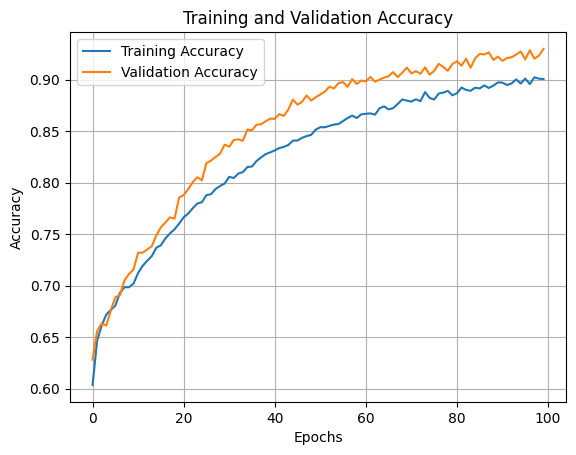

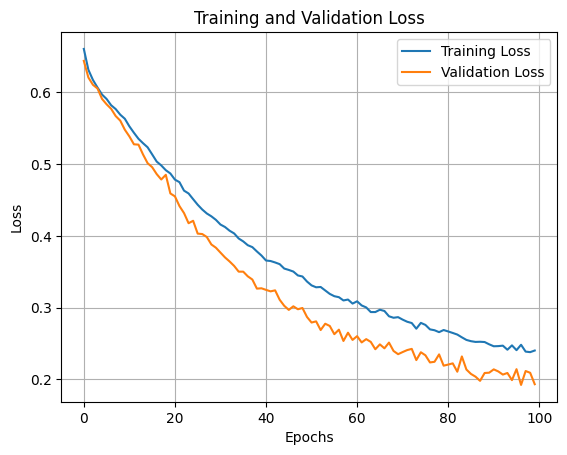

In [6]:
def plot_accuracy(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plt.style.use('default')

plot_accuracy(history5)
plot_loss(history5)

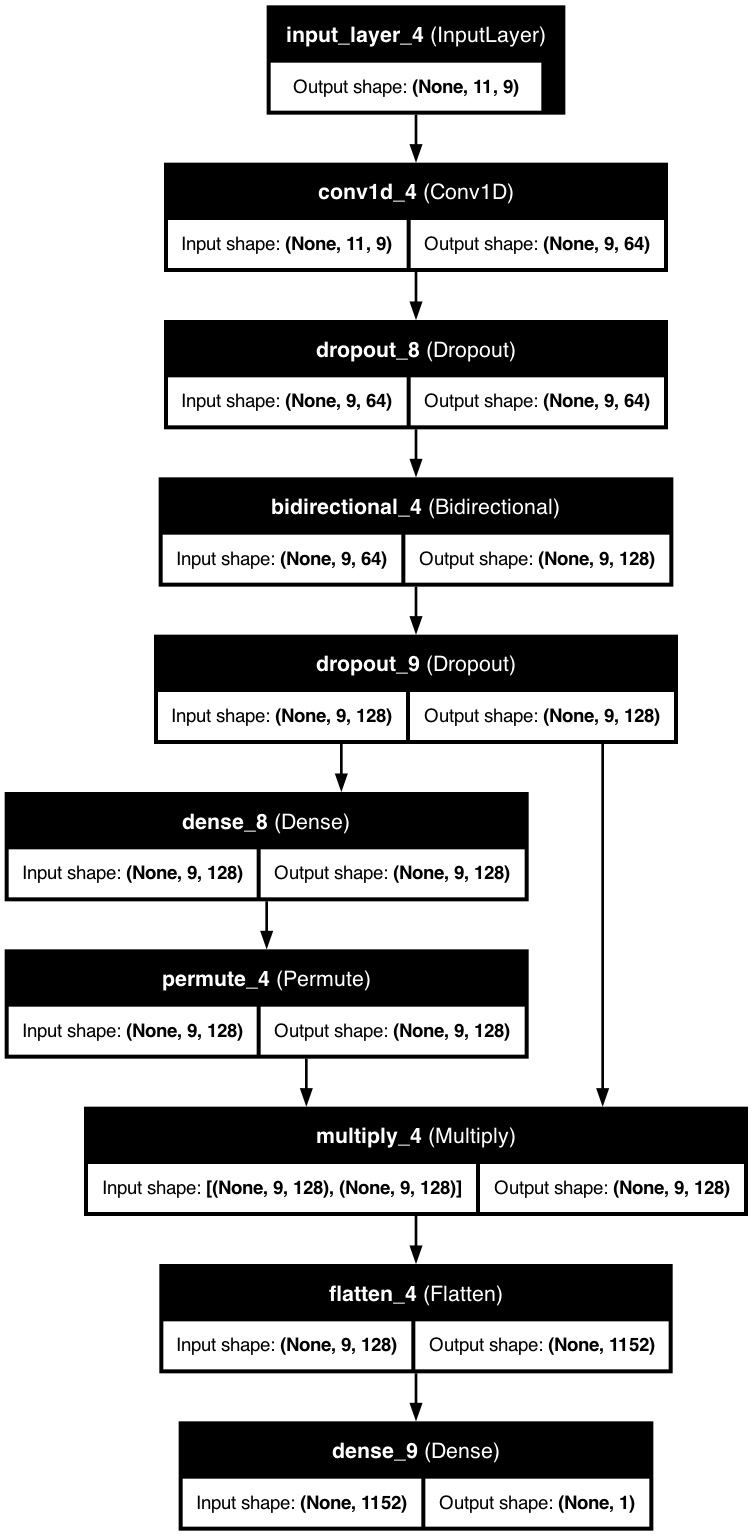

In [12]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already created
plot_model(best_model5, to_file='cnn-bilstm-arch.png', 
           show_shapes=True, 
           show_layer_names=True, 
           rankdir='TB', 
           dpi=96)

In [27]:
import tensorflow as tf 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

def build_lstm_model_l2(input_shape, optimizer='adam', units=64, learning_rate=0.001, l2_lambda=0.00001):
    model = Sequential([
        InputLayer(input_shape=input_shape),  # Explicitly add InputLayer
        LSTM(units, activation='tanh', return_sequences=False,
             kernel_regularizer=l2(l2_lambda),
             recurrent_regularizer=l2(l2_lambda),
             bias_regularizer=l2(l2_lambda)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# def build_lstm_model_l2(input_shape, optimizer='adam', units=64, learning_rate=0.001, l2_lambda=0.00001):
#     model = Sequential([
#         tf.keras.Input(shape=input_shape),
#         LSTM(units, activation='tanh', return_sequences=False,
#              kernel_regularizer=l2(l2_lambda),
#              recurrent_regularizer=l2(l2_lambda),
#              bias_regularizer=l2(l2_lambda)),
#         Dense(64, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])

#     if optimizer == 'adam':
#         opt = Adam(learning_rate=learning_rate)
#     elif optimizer == 'rmsprop':
#         opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#     return model

input_shape = (11, 9)  # Example input shape: 10 timesteps, 5 features

# Build Model
model = build_lstm_model_l2(input_shape)

# Plot the Model
from keras.utils.vis_utils import plot_model

tf.keras.utils.plot_model(model, to_file='lstm_model.png', show_shapes=True)
# plot_model(model, to_file='lstm_model_plot.png', show_shapes=True, show_layer_names=True, dpi=96)

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [21]:
import visualkeras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D


# Visualize the model
visualkeras.layered_view(best_model5, legend=True, to_file='model_custom.png')  # White background, clean design

ModuleNotFoundError: No module named 'visualkeras'

# CNN-BiLSTM - GAN

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Epoch [0/100] | D Loss: 1.3456 | G Loss: 0.6559

==================== Training Set After apply_gan_augmentation ====================
Dataset shape: (19460, 11, 9)
Labels shape: (19460,)

Class Distribution:
-----------------
Class 0.0: 13989 samples (71.89%)
Class 1.0: 5471 samples (28.11%)

Fold 1/5
X_train_resampled shape: (19460, 11, 9)
Input shape for model: (11, 9)
Epoch 1/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.7101 - loss: 0.6122 - val_accuracy: 0.7187 - val_loss: 0.5769
Epoch 2/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7219 - loss: 0.5642 - val_accuracy: 0.7194 - val_loss: 0.5600
Epoch 3/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7

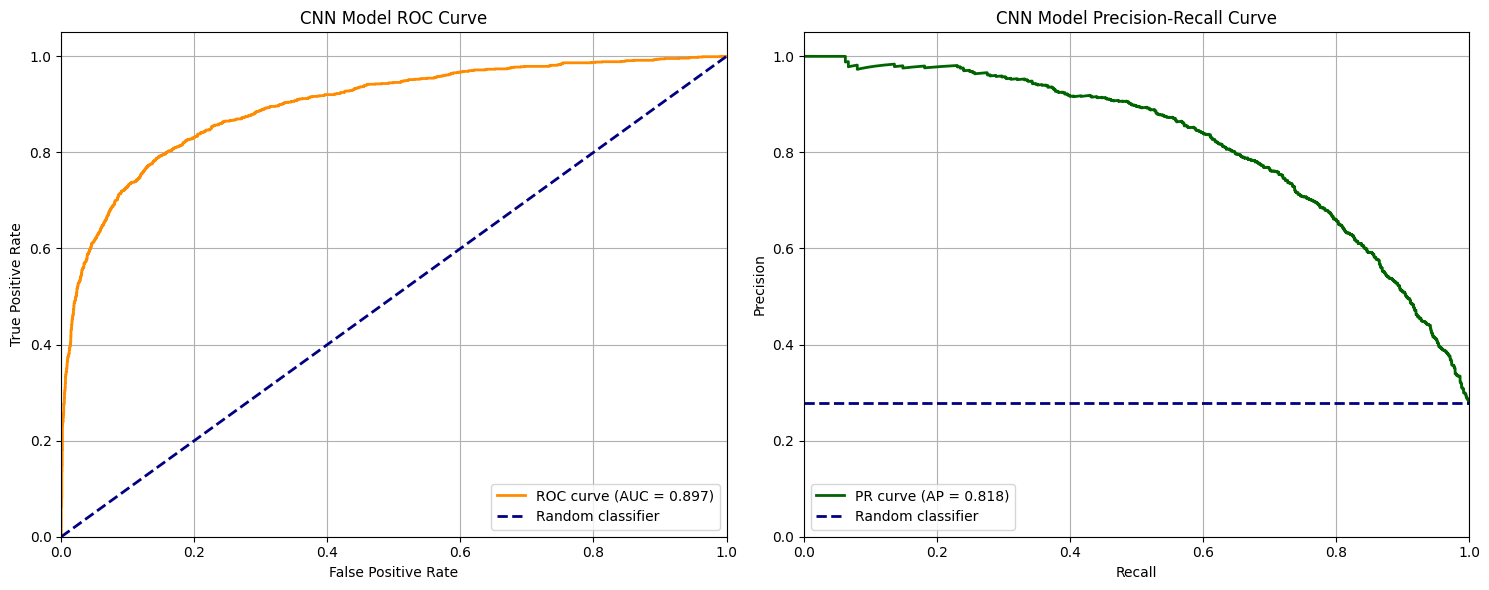

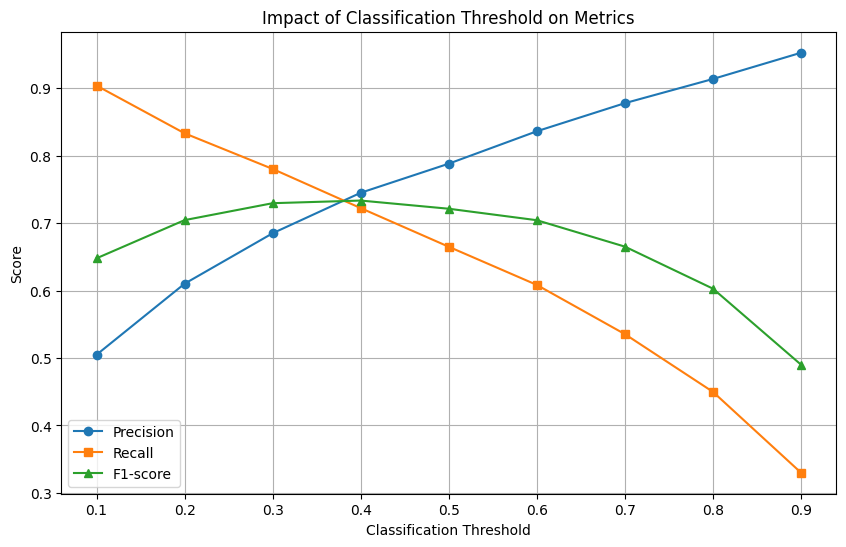


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8969

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8178

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.505, Recall=0.904, F1=0.648
   Threshold 0.2: Precision=0.610, Recall=0.833, F1=0.704
   Threshold 0.3: Precision=0.685, Recall=0.780, F1=0.730
   Threshold 0.4: Precision=0.745, Recall=0.722, F1=0.733
   Threshold 0.5: Precision=0.788, Recall=0.665, F1=0.721
   Threshold 0.6: Precision=0.836, Recall=0.608, F1=0.704
   Threshold 0.7: Precision=0.878, Recall=0.535, F1=0.665
   Threshold 0.8: Precision=0.914, Recall=0.450, F1=0.603
   Threshold 0.9: Precision=0.953, Recall=0.330, F1=0.490
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Cross-Validation Results:
Accuracy: 0.8535 ± 0.0075
Precision: 0.7864 ± 0.0203
Recall: 0.6587 ± 0.0329
F1: 0.7162 ± 0.0192

Test Se

In [11]:
import torch 
import torch.nn as nn
import numpy as np

cv_scores6, test_metrics6, best_model6, history6 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_cnn_bilstm_hybrid_model_2, augmentation_fn=apply_gan_augmentation, 
    window_size=11, step_size=1
)

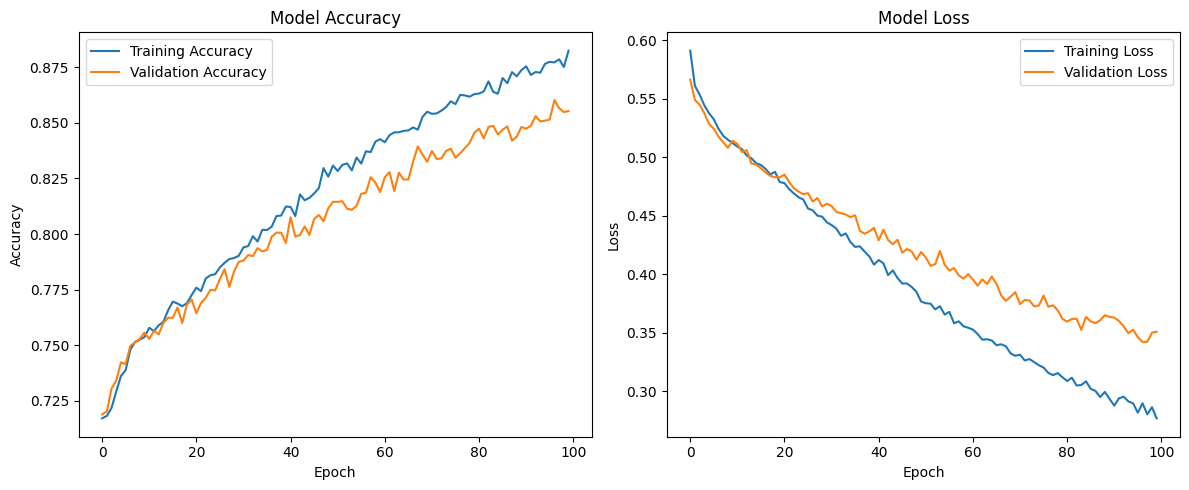

In [12]:
def plot_performance(history):
    # plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_performance(history6)

what is sequence transformers?
https://www.reddit.com/r/learnmachinelearning/comments/ujnv7o/comment/i7k1n24/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button 